 # 神经网络

 **学习目标：**
  * 使用 TensorFlow `DNNRegressor` 类定义神经网络 (NN) 及其隐藏层
  * 训练神经网络学习数据集中的非线性规律，并实现比线性回归模型更好的效果

 在之前的练习中，我们使用合成特征来帮助模型学习非线性规律。

一组重要的非线性关系是纬度和经度的关系，但也可能存在其他非线性关系。

现在我们从之前练习中的逻辑回归任务回到标准的（线性）回归任务。也就是说，我们将直接预测 `median_house_value`。

 ## 设置

首先加载和准备数据。

In [14]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics,datasets
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

boston_data = datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)
df_boston = df_boston.reindex(np.random.permutation(df_boston.index))

boston_housing_dataframe = df_boston
df_target = pd.DataFrame(boston_housing_dataframe.pop("target"),columns=["target"])
df_boston = boston_housing_dataframe

In [17]:
def preprocess_features(boston_housing_dataframe):

  selected_features = boston_housing_dataframe[
    [  "CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT"]]
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(df_target):
  output_targets = pd.DataFrame()
  output_targets["target"] = df_target["target"]
  return output_targets

In [18]:
training_examples = preprocess_features(df_boston.head(350))
training_targets = preprocess_targets(df_target.head(350))

validation_examples = preprocess_features(df_boston.tail(156))
validation_targets = preprocess_targets(df_target.tail(156))

 ## 构建神经网络

神经网络由 [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNRegressor) 类定义。

使用 **`hidden_units`** 定义神经网络的结构。`hidden_units` 参数会创建一个整数列表，其中每个整数对应一个隐藏层，表示其中的节点数。以下面的赋值为例：

`hidden_units=[3,10]`

上述赋值为神经网络指定了两个隐藏层：

* 第一个隐藏层包含 3 个节点。
* 第二个隐藏层包含 10 个节点。

如果我们想要添加更多层，可以向该列表添加更多整数。例如，`hidden_units=[10,20,30,40]` 会创建 4 个分别包含 10、20、30 和 40 个单元的隐藏层。

默认情况下，所有隐藏层都会使用 ReLu 激活函数，且是全连接层。

In [19]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [20]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [21]:
def train_nn_regression_model( learning_rate, steps, batch_size, hidden_units,
    training_examples, training_targets, validation_examples, validation_targets):

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["target"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["target"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["target"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print "Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error
  print "Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error

  return dnn_regressor

 ## 训练神经网络模型

运行以下代码块来训练神经网络模型。在此练习中，您的任务是修改各种学习设置，以提高在验证数据上的准确率。对于神经网络而言，过拟合是一种真正的潜在危险。您可以查看训练数据损失与验证数据损失之间的差值，以帮助判断模型是否有过拟合的趋势。如果差值开始变大，则通常可以肯定存在过拟合。由于存在很多不同的可能设置，强烈建议您记录每次试验，以在开发流程中进行参考。此外，获得效果出色的设置后，尝试多次运行该设置，看看结果的重复程度。由于神经网络权重通常会初始化为较小的随机值，因此每次运行结果应该存在差异。

Training model...
RMSE (on training data):
  period 00 : 9.69
  period 01 : 9.70
  period 02 : 8.99
  period 03 : 9.16
  period 04 : 9.28
  period 05 : 8.27
  period 06 : 8.54
  period 07 : 7.96
  period 08 : 7.89
  period 09 : 8.06
Model training finished.
Final RMSE (on training data):   8.06
Final RMSE (on validation data): 6.91


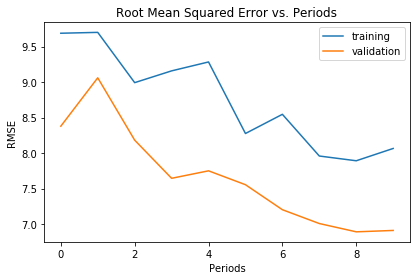

In [22]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 7.44
  period 01 : 6.80
  period 02 : 6.09
  period 03 : 5.98
  period 04 : 5.61
  period 05 : 5.32
  period 06 : 5.27
  period 07 : 5.30
  period 08 : 5.10
  period 09 : 5.11
Model training finished.
Final RMSE (on training data):   5.11
Final RMSE (on validation data): 5.65


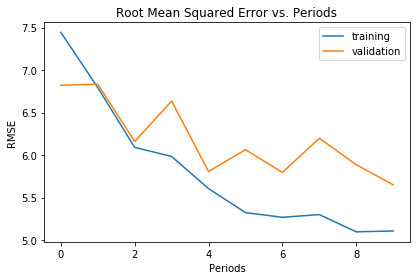

In [23]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 # 提高神经网络性能
**学习目标**：通过将特征标准化并应用各种优化算法来提高神经网络的性能

In [24]:
def train_nn_regression_model( my_optimizer, steps, batch_size, hidden_units,
    training_examples, training_targets, validation_examples, validation_targets):

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["target"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["target"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["target"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print "Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error
  print "Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error

  return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 7.00
  period 01 : 7.07
  period 02 : 7.19
  period 03 : 7.00
  period 04 : 7.09
  period 05 : 7.21
  period 06 : 6.85
  period 07 : 7.13
  period 08 : 6.83
  period 09 : 6.81
Model training finished.
Final RMSE (on training data):   6.81
Final RMSE (on validation data): 6.78


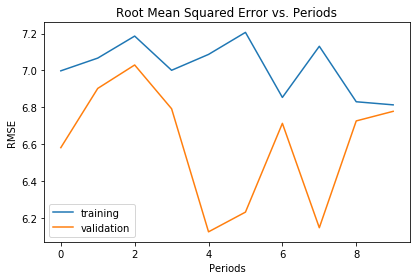

In [25]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 线性缩放
将输入标准化以使其位于 (-1, 1) 范围内可能是一种良好的标准做法。这样一来，SGD不会出现在一个维度中采用很大步长而在另一维度中采用很小步长。

In [27]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

Training model...
RMSE (on training data):
  period 00 : 6.28
  period 01 : 4.35
  period 02 : 4.17
  period 03 : 4.02
  period 04 : 3.84
  period 05 : 3.64
  period 06 : 3.47
  period 07 : 3.31
  period 08 : 3.16
  period 09 : 3.10
Model training finished.
Final RMSE (on training data):   3.10
Final RMSE (on validation data): 4.09


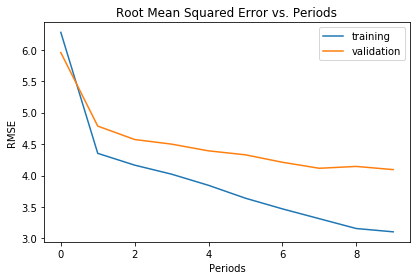

In [29]:
def normalize_linear_scale(examples_dataframe):

  processed_features = pd.DataFrame()
  processed_features["CRIM"] = linear_scale(examples_dataframe["CRIM"])
  processed_features["ZN"] = linear_scale(examples_dataframe["ZN"])
  processed_features["INDUS"] = linear_scale(examples_dataframe["INDUS"])
  processed_features["CHAS"] = linear_scale(examples_dataframe["CHAS"])
  processed_features["NOX"] = linear_scale(examples_dataframe["NOX"])
  processed_features["RM"] = linear_scale(examples_dataframe["RM"])
  processed_features["AGE"] = linear_scale(examples_dataframe["AGE"])
  processed_features["DIS"] = linear_scale(examples_dataframe["DIS"])
  processed_features["RAD"] = linear_scale(examples_dataframe["RAD"])
  processed_features["TAX"] = linear_scale(examples_dataframe["TAX"])
  processed_features["PTRATIO"] = linear_scale(examples_dataframe["PTRATIO"])
  processed_features["B"] = linear_scale(examples_dataframe["B"])
  processed_features["LSTAT"] = linear_scale(examples_dataframe["LSTAT"])    
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(boston_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(350)
normalized_validation_examples = normalized_dataframe.tail(156)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## 尝试其他优化器

** 使用 AdaGrad 和 Adam 优化器并对比其效果。**

AdaGrad 优化器是一种备选方案。AdaGrad 的核心是灵活地修改模型中每个系数的学习率，从而单调降低有效的学习率。该优化器对于凸优化问题非常有效，但不一定适合非凸优化问题的神经网络训练。您可以通过指定 `AdagradOptimizer`（而不是 `GradientDescentOptimizer`）来使用 AdaGrad。请注意，对于 AdaGrad，您可能需要使用较大的学习率。

对于非凸优化问题，Adam 有时比 AdaGrad 更有效。要使用 Adam，请调用 `tf.train.AdamOptimizer` 方法。此方法将几个可选超参数作为参数，但我们的解决方案仅指定其中一个 (`learning_rate`)。在应用设置中，您应该谨慎指定和调整可选超参数。

首先，我们来尝试 AdaGrad。

Training model...
RMSE (on training data):
  period 00 : 4.49
  period 01 : 4.63
  period 02 : 3.98
  period 03 : 3.99
  period 04 : 3.52
  period 05 : 3.40
  period 06 : 3.26
  period 07 : 3.53
  period 08 : 3.66
  period 09 : 2.93
Model training finished.
Final RMSE (on training data):   2.93
Final RMSE (on validation data): 3.97


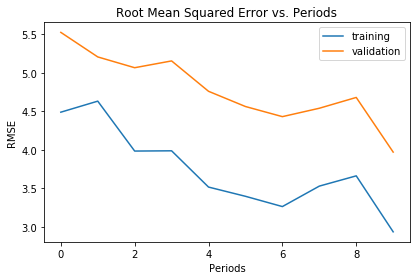

In [31]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 现在，我们来尝试 Adam。

Training model...
RMSE (on training data):
  period 00 : 7.54
  period 01 : 4.28
  period 02 : 4.06
  period 03 : 3.73
  period 04 : 3.43
  period 05 : 3.26
  period 06 : 3.21
  period 07 : 3.10
  period 08 : 3.04
  period 09 : 3.11
Model training finished.
Final RMSE (on training data):   3.11
Final RMSE (on validation data): 3.96


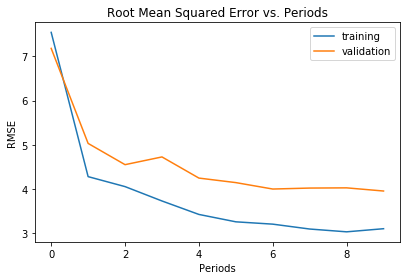

In [32]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 我们并排输出损失指标的图表。

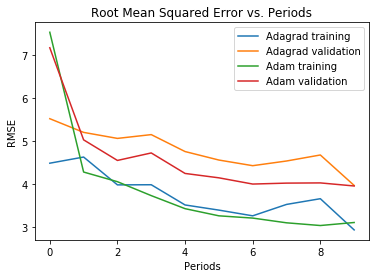

In [33]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

## 尝试其他标准化方法

**尝试对各种特征使用其他标准化方法，以进一步提高性能。**

如果仔细查看转换后数据的汇总统计信息，你可能会注意到，很多特征的中位数不是 `0.0`。

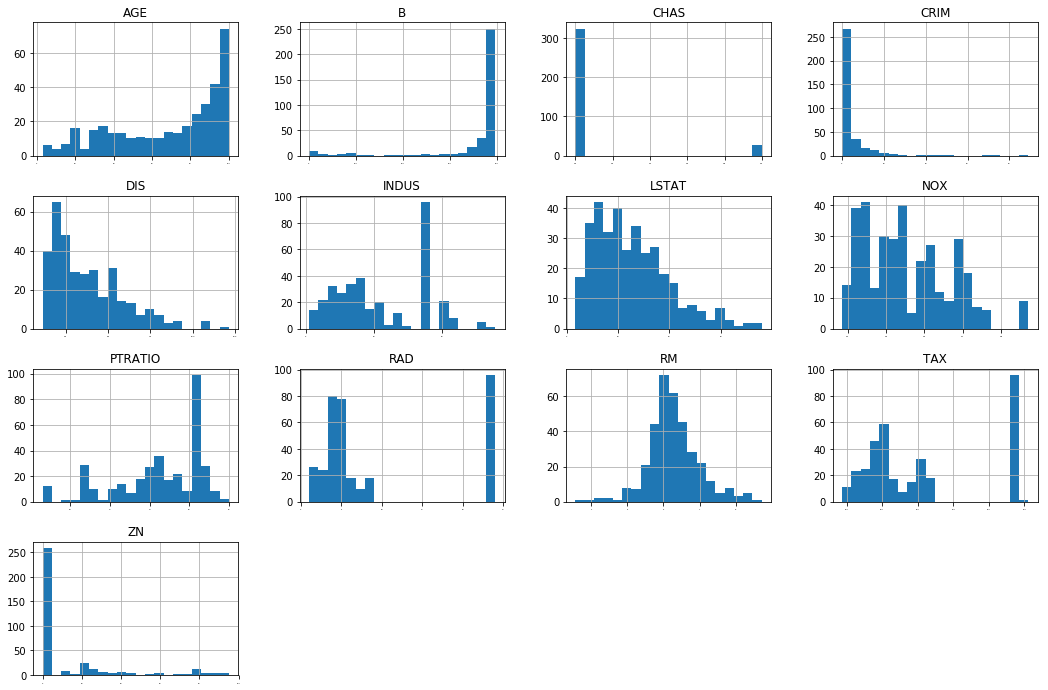

In [34]:
_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=2)

通过选择其他方式来转换这些特征，我们可能会获得更好的效果。

例如，对数缩放可能对某些特征有帮助。或者，截取极端值可能会使剩余部分的信息更加丰富。

In [35]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

Training model...
RMSE (on training data):
  period 00 : 3.93
  period 01 : 3.34
  period 02 : 3.10
  period 03 : 3.18
  period 04 : 2.81
  period 05 : 2.83
  period 06 : 2.72
  period 07 : 2.66
  period 08 : 2.55
  period 09 : 2.50
Model training finished.
Final RMSE (on training data):   2.50
Final RMSE (on validation data): 4.06


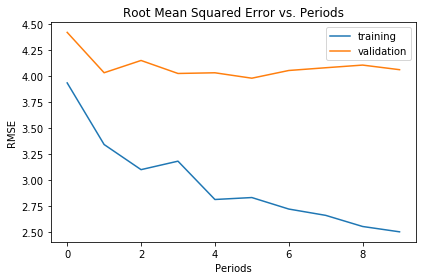

In [36]:
def normalize(examples_dataframe):
  processed_features = pd.DataFrame()

  processed_features["CRIM"] = log_normalize(examples_dataframe["CRIM"])
  processed_features["ZN"] = log_normalize(examples_dataframe["ZN"])
  processed_features["B"] = log_normalize(examples_dataframe["B"])
  
  processed_features["INDUS"] = linear_scale(examples_dataframe["INDUS"])
  processed_features["CHAS"] = linear_scale(examples_dataframe["CHAS"])
  processed_features["NOX"] = linear_scale(examples_dataframe["NOX"])
  processed_features["RM"] = linear_scale(examples_dataframe["RM"])
  processed_features["AGE"] = linear_scale(examples_dataframe["AGE"])
  processed_features["DIS"] = linear_scale(examples_dataframe["DIS"])
  processed_features["RAD"] = linear_scale(examples_dataframe["RAD"])
  processed_features["TAX"] = linear_scale(examples_dataframe["TAX"])
  processed_features["PTRATIO"] = linear_scale(examples_dataframe["PTRATIO"])
  processed_features["LSTAT"] = linear_scale(examples_dataframe["LSTAT"])

  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(boston_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(350)
normalized_validation_examples = normalized_dataframe.tail(156)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)